# PyTorch Tutorial: Building and Training a CNN from Scratch

## Learning Outcomes 
By the end of this tutorial, you will be able to: 

1. **Work with PyTorch Tensors:** Create and manipulate tensors in PyTorch and understand how to move computations to the GPU for acceleration. 

2. **Get the gradient of a function with respect to its input:** Use PyTorch's `autograd` to compute gradients of a function with respect to its inputs.

3. **Build a Convolutional Neural Network (CNN):** Define a simple CNN architecture in pytorch using `torch.nn.Module`, including convolutional layers, activation functions, and fully connected layers.

4. **Evaluate a Model:** Implement a forward pass to compute predictions from a trained model and evaluate its performance using metrics like accuracy and a confusion matrix.

4. **Train a Model:** Implement a training loop that performs forward passes, computes loss, performs backpropagation, and updates parameters with an optimizer. You’ll also learn to monitor training progress and performance during training (e.g. tracking loss over epochs).

5. **Evaluate After Training and Debug Models:** Identify signs of overfitting vs. underfitting during training and apply remedies (like adjusting learning rate, changing batch size, or adding regularization). You’ll also practice saving model checkpoints and using basic logging to track experiments for debugging and improving training runs.

**Tutorial Structure:** The idea is that you should follow along with your own laptop and run the code as we go. I will explain each step and give you time to try it out. I will also provide some exercises for you to practice on your own.

---

## Part 1: Introduction to PyTorch Tensors



### 1.1 Working with PyTorch Tensors (and GPUs)


#### 1.1.1 Similarities between `numpy.ndarray` and `torch.Tensor`
PyTorch’s core data structure is the **Tensor**, an n-dimensional array much like NumPy’s `ndarray`, with additional features such as GPU support and automatic differentiation.  
📚 [PyTorch Documentation on Tensors](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#tensors)


In [0]:
## Similarities between numpy and pytorch
import numpy as np
import torch


## numpy
print("Numpy\n------")
x = np.array([[1, 2], [3, 4]])
print(x)
print(x.dtype, x.shape)
x.sum(0)
print(x[0])
print(x[0, 0])
print(x[:, 0])
print(x == 1)

grid = np.random.randn(2, 2)
print(grid)

print()


## pytorch
print("PyTorch\n------")
x = torch.tensor([[1, 2], [3, 4]])
print(x)
print(x.dtype, x.shape)
x.sum(0)
print(x[0])
print(x[0, 0])
print(x[:, 0])
print(x == 1)

grid = torch.randn(2, 2)
print(grid)

Numpy
------
[[1 2]
 [3 4]]
int64 (2, 2)
[1 2]
1
[1 3]
[[ True False]
 [False False]]
[[ 1.57393107 -0.02987315]
 [-1.7381737   0.66322832]]

PyTorch
------
tensor([[1, 2],
        [3, 4]])
torch.int64 torch.Size([2, 2])
tensor([1, 2])
tensor(1)
tensor([1, 3])
tensor([[ True, False],
        [False, False]])
tensor([[-0.0945, -0.1519],
        [-0.5760,  1.8791]])


Similarities (think of PyTorch as a GPU-accelerated NumPy):
- Indexing and slicing syntax are identical
- Data types and shapes behave similarly
- Operations like `.sum()`, element-wise comparison, etc. feel the same

#### 1.1.2 Important differences between `numpy.ndarray` and `torch.Tensor`
| Feature | numpy.ndarray | torch.Tensor |
--- | --- | ---| 
| GPU support | ❌ CPU only | ✅ GPU or CPU |
| Automatic differentiation | ❌ Not supported | ✅ `.requires_grad` and `.backward()` |
| In-place operation safety | Not enforced | ⚠️ Can interfere with autograd |
| Integration with deep learning frameworks | ❌ | ✅ (nn, optim, etc.) |


In [0]:
## If you have a mac with an M-chip, try with "mps" instead of "cuda" on the line below
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
x = x.to(device)
print(x.device)

# In-place operation caveat
a = torch.tensor([1.0, 2.0], requires_grad=True)
try:
    a += 1  ## in-place operations with grad are not allowed
except RuntimeError as e:
    print(f"RuntimeError: {e}")

cpu
cpu
RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.


#### 1.1.3 Conversion between `numpy.ndarray` and `torch.Tensor`

In [0]:
# NumPy to PyTorch (straightforward)
x_np = np.array([[1, 2], [3, 4]])
x_torch = torch.from_numpy(x_np)
print(type(x_torch), x_torch)

# PyTorch to NumPy (not so straightforward)
x_back = x_torch.numpy()
## If requires_grad=True, then we must explicitly throw away the gradient information using detach()
x_back = x_torch.detach().numpy()
## if on the gpu as well we need to move it to the cpu first
x_back = x_torch.detach().cpu().numpy()
print(type(x_back), x_back)

<class 'torch.Tensor'> tensor([[1, 2],
        [3, 4]])
<class 'numpy.ndarray'> [[1 2]
 [3 4]]


**Memory sharing alert!:**
- `from_numpy()` creates a tensor that shares memory with the original array.
- Changes to the NumPy array will affect the tensor (and vice versa).

In [0]:
x_np[0, 0] = 999
print("Torch tensor after modifying original NumPy array:", x_torch)

Torch tensor after modifying original NumPy array: tensor([[999,   2],
        [  3,   4]])


#### 1.1.4 Gradients and Automatic Differentiation (the simple way)
PyTorch’s `autograd` package provides automatic differentiation for all operations on Tensors. It does this by keeping track of operations performed on Tensors and calculating the gradients with respect to the input. 

In the first mandatory assignment, we built a network that kept track of activations and gradients for each layer separately. In pytorch, gradients are kept track of automatically and stored in the `.grad` attribute of each tensor.

**Example:**

In [0]:
x = torch.tensor(2.0, requires_grad=True)


def f(x):
    return x**3


out = f(x)

## Compute the gradient of the output with respect to the input(s)
## Note that this needs to be a scalar or be given a vector of the same shape as the output
out.backward()

print(f"{x=}")
print(f"{out=}")
print(f"{x.grad=}")

x=tensor(2., requires_grad=True)
out=tensor(8., grad_fn=<PowBackward0>)
x.grad=tensor(12.)


**Notice:**

`out`  is a scalar here. 
If not, we would need to provide a vector of the same shape as `out` to `backward()`, similar to the $\delta$-values in the mandatory assignment.

--- 

### 1.2 Exercises for Working with PyTorch Tensors (and GPUs)

#### Ex. 1 Memory sharing: Who's in change?

In [0]:
import numpy as np
import torch

# Step 1: Create a NumPy array and convert it to a torch tensor
arr = np.arange(9).reshape(3, 3)
tensor = torch.from_numpy(arr)

# Step 2: Modify the torch tensor
tensor[0, 0] = 999

# Step 3: Print both
print("Modified NumPy array:\n", arr)
print("Modified Tensor:\n", tensor)

Modified NumPy array:
 [[999   1   2]
 [  3   4   5]
 [  6   7   8]]
Modified Tensor:
 tensor([[999,   1,   2],
        [  3,   4,   5],
        [  6,   7,   8]])


**Questions**
1. Is the relationship symmetric?
2. How can you break this connection and make a safe copy? (Experiment with `.clone()`, `.detach()`, and `.copy()`)

---

**Okay! Now we have covered the basics of working with PyTorch tensors. Let's move on to the next section where we will build and train a simple Deep Learning model.**

## Part 2: Building and Training a Neural Network

### Overview

We’ll now walk through the full process of defining, training, and evaluating a CNN using PyTorch. We'll work step by step:
1. Datasets and Dataloaders
2. Model
3. Loss 
4. Optimizer
5. Metric (**quality measure**) to evaluate the model
6. Evaluation of the model
7. Train model (forward, backward, update parameters)
8. Evaluate model performance on test set
9. Save and load model
10. Make predictions on new data
<!-- 11. Custom dataset and dataloaders -->


### 2.1 Dataset and Dataloaders

At this point. I will just give you a dataset to start working with to get the process going. However, we will revisit datasets and dataloaders after we have trained the network. **Do not worry if the next cell is confusing, we will go through the important parts later**.

In [0]:
## MNIST Data
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

classes = list(range(10))
## Download and split the dataset into training, validation, and test sets
train_val_data = torchvision.datasets.MNIST(
    root="../data", train=True, download=True, transform=transforms.ToTensor()
)
train_dataset, val_dataset = torch.utils.data.random_split(
    train_val_data, [50000, 10000]
)

test_dataset = torchvision.datasets.MNIST(
    root="../data", train=False, download=True, transform=transforms.ToTensor()
)

print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(val_dataset)}")
print(f"Number of testing examples: {len(test_dataset)}")
## Create data loaders
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=batch_size, shuffle=False
)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)

print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of validation batches: {len(val_dataloader)}")
print(f"Number of testing batches: {len(test_dataloader)}")

Number of training examples: 50000
Number of validation examples: 10000
Number of testing examples: 10000
Number of training batches: 782
Number of validation batches: 157
Number of testing batches: 157


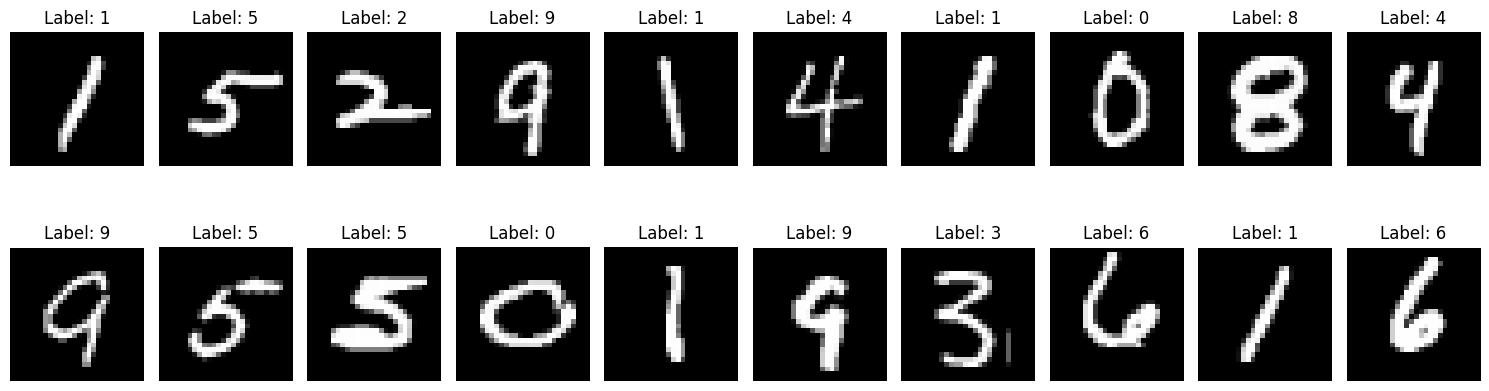

In [0]:
def plot_examples(mnist_dataset, model=None):
    fig, axes = plt.subplots(2, 10, figsize=(15, 5))

    for i, ax in enumerate(axes.flat):
        ## Get a random image from the dataset
        idx = random.randint(0, len(mnist_dataset))
        img, label = mnist_dataset[idx]
        ax.imshow(img[0], cmap="gray")

        ## add prediction if model is provided
        if model is not None:
            ## Apply the model to the image
            pred = model(img.unsqueeze(0)).detach().numpy()
            pred_label = pred.argmax()
            ax.set_title(f"Label: {label}\nPred: {pred_label}")
        else:
            ax.set_title(f"Label: {label}")

        ax.axis("off")
    plt.tight_layout()
    plt.show()


plot_examples(test_dataset)

In [0]:
# ## CIFAR-10 Data (similar to MNIST, but with color images), image size is 3x32x32
# import torch
# import torchvision
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt
# import numpy as np

# ## Constants
# batch_size = 4


# ## Define the transformation to apply to the images
# transform = transforms.Compose(
#     [
#         transforms.ToTensor(), ## Converts the image to a PyTorch tensor and scales the pixel intensity values in the range [0, 1]
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#     ]
# )

# ## Download (if necessary) and load the CIFAR-10 dataset
# train_val_data = torchvision.datasets.CIFAR10(
#     root="../data", train=True, download=True, transform=transform
# )

# ## Split the dataset into training and validation sets (one the model can see, the other it can't)
# train_dataset, val_dataset = torch.utils.data.random_split(train_val_data, [40000, 10000])


# train_dataloader = torch.utils.data.DataLoader(
#     train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
# )

# val_dataloader = torch.utils.data.DataLoader(
#     val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
# )

# ## Load the test set
# test_dataset = torchvision.datasets.CIFAR10(
#     root="../data", train=False, download=True, transform=transform
# )
# test_dataloader = torch.utils.data.DataLoader(
#     test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
# )

# classes = (
#     "plane",
#     "car",
#     "bird",
#     "cat",
#     "deer",
#     "dog",
#     "frog",
#     "horse",
#     "ship",
#     "truck",
# )


# def show_cifar_batch(batch):
#     images, labels = batch
#     batch_size = len(images)
#     grid = torchvision.utils.make_grid(images, nrow=batch_size)
#     grid = grid.numpy().transpose((1, 2, 0))
#     grid = grid / 2 + 0.5
#     plt.imshow(grid)
#     plt.axis("off")
#     plt.show()
#     print(" ".join(f"{classes[labels[j]]:15s}" for j in range(batch_size)))


# # get some random training images
# dataiter = iter(train_dataloader)
# images, labels = next(dataiter)

# # show images
# show_cifar_batch((images, labels))

In [0]:
## Understand the data format
images, labels = next(iter(train_dataloader))
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


### 2.2 Defining a Model using `nn.Module`

When subclassing `nn.Module`, we must specify one method, `forward()`, which defines the forward pass of the network. The `__init__()` method is used to define the layers of the network if that is needed. `forward()` is called when we pass data through the model as `model(data)`.

In [1436]:
import torch
import torch.nn as nn


class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        """Small CNN model for MNIST.

        # Assumes input images are of size (3, 32, 32).
        Assumes input images are of size (1, 28, 28).
        """
        super().__init__()
        ## Define the layers
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)

        self.fc1 = nn.Linear(64 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        ## Define the forward pass
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = CNN(in_channels=1, num_classes=10)

## try with resnet18
# import torchvision.models as models
# model = models.resnet18(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, 10)


## If GPU is available, move model and data to GPU for faster computation, otherwise use CPU

print(f"Using device: {device}")

## Move model to device
model = model.to(device)
print(model)

Using device: cpu
CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [1437]:
## Predict a sample image

## Get a sample image from the data loader (first batch)
image, label = next(iter(train_dataloader))
## Move image and label to device
image = image.to(device)
label = label.to(device)

## Apply the model to the image
pred = model(image)

print(image.shape)
print(pred.shape)
print(label.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 10])
torch.Size([64])


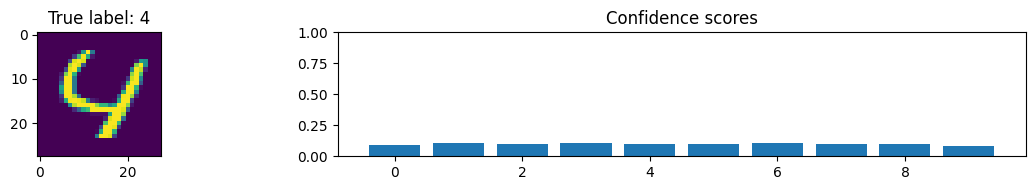

In [1438]:
## Show confidence scores for each class for the first sample
fig, ax = plt.subplots(1, 2, figsize=(13, 2))
ax[0].imshow(image[0].permute(1, 2, 0).cpu().numpy())
ax[0].set_title(f"True label: {classes[label[0].item()]}")
ax[1].bar(classes, pred[0].softmax(0).detach().cpu().numpy())
ax[1].set_ylim([0, 1])
ax[1].set_title("Confidence scores")
plt.tight_layout()
plt.show()

### 2.3 Loss Function

Loss function (also referred to as the objective function, cost function or criterion) does 2 things:
1. Quantifies how well the model is performing. 
2. Provides a signal to the optimizer on how to update the weights.

Loss functions in PyTorch can be regular Python functions, but usually they are implemented as `nn.Module` subclasses and many of them are already implemented in `torch.nn`. Two loss functions we have seen before are the cross-entropy loss (in combination with softmax) and the mean squared error loss. We will use the cross-entropy loss in this tutorial.
Below you can see two versions of cross-entropy-loss. One form the pytorch library, but also a manual implementation. I wanted you to know that loss functions in pytorch are just functions that take the predictions and the targets as input and return a scalar value. PyTorch have many implemented that are optimized for speed and numerical stability, but usually, the manual implementation is a good way to understand what is going on and the penalty is usually not that big since the loss function is only calculated once per batch anyway and does not contribute that much to the total training time. 

In [0]:
loss_function = nn.CrossEntropyLoss()

In [0]:
def home_made_cross_entropy(pred, target):
    ## Compute the softmax of the predictions
    ## softmax
    pred = pred.exp()
    pred = pred / pred.sum(1, keepdim=True)

    ## Compute the negative log likelihood
    loss = 0
    for i in range(len(pred)):
        ## 1 * log(pred) + 0 * log(1 - pred) = log(pred) for the target class
        loss -= pred[i, target[i]].log()
    return loss / len(pred)


print("torch version: ", loss_function(pred, label))
print("manual version: ", home_made_cross_entropy(pred, label))

torch version:  tensor(2.2999, grad_fn=<NllLossBackward0>)
manual version:  tensor(2.2999, grad_fn=<DivBackward0>)


### 2.4 Optimizer

In the lectures, you have seen several optimization algorithms: Gradient Descent, Stochastic Gradient Descent, Adaptable Gradient Descent (AdaGrad), Adaptive Moment Estimation (Adam), and more. 

The way the optimization algorithms are handled in PyTorch is by defining an **Optimizer** that gets 
1. `model.parameters()`: The parameters to be optimized (which all have gradients attached to them as we have seen with the tensors). If only fine tuning the head of a pre-trained model, you can pass in only the parameters of the head.
2. Hyperparameters to the optimizer such as learning rate, momentum, etc.

**Adam** and **SGD** with momentum are common default choices and usually work well, but I encourage you to experiment with different optimizers and hyperparameters to see how they affect the training.

In [0]:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

### 2.5 Metrics for Evaluation

To be able to tell if our model is actually doing well, we need a measure of quality of its predictions. Often, there are pairs of loss functions and metrics that do similar things, but they are usually not exactly the same. The main reason for the difference is that the loss function needs to be differentiable with respect to parameters of the model (for the optimization), while the metric does not. Therefore, the requirements for the metric are more relaxed so the __metric can be more aligned with the actual problem we are trying to solve.__

Note that in actual usage, choosing a reasonable metric is a really important parts of a deep learning system. The complexity of deep learning models make them able to model very complex relationships between inputs, but that flexibility is a blessing and a curse. The ability to model arbitrarily complex patterns also means we cannot assume the patterns aren't arbitrarily complex, making validation and interpretation hard.

Choosing the right quality measure or **metric** is crucial to understanding how well the model is performing for the purpose it is intended for.

In this tutorial we will only use one metric: **accuracy** to start with as the validation is not the main lesson here. However, I encourage you investigate different metrics for your own projects. 

<!-- 
Different metrics can give different perspectives on the performance of the model. For example, in a binary classification problem, the accuracy can be misleading if the classes are imbalanced. Eg. if one class makes up 90% of the data, a model that always predicts that class will have 90% accuracy, but still be a horrible model. 

**Metrics we will use here:**
- **Accuracy** is the most common metric for classification problems. It is the ratio of correctly predicted observations to the total observations.
- **Precision** is the ratio of correctly predicted positive observations to the total predicted positive observations.
- **Recall** is the ratio of correctly predicted positive observations to the all observations in actual class.
- **Dice Score** is a metric used for segmentation tasks. It is the harmonic mean of precision and recall, but can also be seen as a sort of overlap measure. 


This will be used for both validation and monitoring during training. -->

In [0]:
def accuracy(soft_pred, target):
    """The number of correct predictions divided by the number of total predictions."""
    return (soft_pred.argmax(dim=1) == target).float().mean()

In [0]:
def confusion_matrix(soft_pred, target):
    """Compute the confusion matrix. Rows represent the true class, columns represent the predicted class.
    This can be useful for understanding which classes are being confused."""
    num_samples = soft_pred.shape[0]
    num_classes = soft_pred.shape[1]
    confusion_matrix = torch.zeros(num_classes, num_classes)
    predicted = soft_pred.argmax(1)
    for i in range(num_samples):
        confusion_matrix[target[i], predicted[i]] += 1
    return confusion_matrix

> Important: Even before training, we want to measure how good our model is *randomly initialized*. This gives us a baseline and gives us an idea of how good "as good as random" is.

### 2.6 Evaluation of the Model (baseline)

How good does our model do? Let's evaluate it on the validation set before training starts to get a baseline. 

In [0]:
def evaluate(model, dataloader):
    ## Set model to evaluation mode (important for dropout and batch normalization layers)
    model.eval()
    ## Initialize tracking variables
    loss_track = 0
    acc_track = 0

    ## Initialize confusion matrix
    con_mat_track = torch.zeros(10, 10)

    with torch.inference_mode():  ## also works with torch.no_grad(), but torch.inference_mode() is more explicit, future-proof and preferred
        for inputs, labels in dataloader:
            ## Move data to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            ## Forward pass
            outputs = model(inputs)

            ## Compute loss
            loss = loss_function(outputs, labels)

            ## Compute metrics
            acc = accuracy(outputs, labels)
            con_mat = confusion_matrix(outputs, labels)

            ## Update statistics
            loss_track += loss.item()
            acc_track += acc
            con_mat_track += con_mat

        ## Compute average loss and accuracy
        loss_track /= len(dataloader)
        acc_track /= len(dataloader)
    return loss, acc, con_mat_track

In [0]:
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(cm, cmap="Blues")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(i, j, f"{cm[j, i]:.0f}", ha="center", va="center")

    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.tight_layout()
    plt.show()

Before training: Val loss = 2.2991, Val accuracy = 0.1250
Confusion matrix:


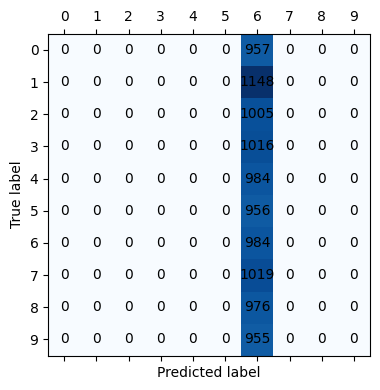

In [0]:
## Evaluate the model on the validation set
val_loss, val_acc, con_mat = evaluate(model.to(device), val_dataloader)
print(f"Before training: Val loss = {val_loss:.4f}, Val accuracy = {val_acc:.4f}")
print("Confusion matrix:")
plot_confusion_matrix(con_mat)

What types of errors are we making? Let's remove the diagonal from the confusion matrix (where the prediction and the true class are the same) to get a more fine grain understanding of the errors.

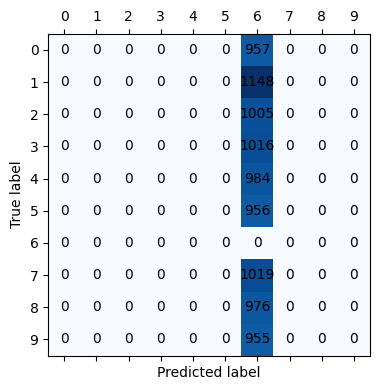

In [0]:
## Subtract the diagonal to only show the errors
con_mat_non_diag = con_mat - torch.eye(10) * con_mat.diag()
plot_confusion_matrix(con_mat_non_diag)

### 2.7 Train model (forward, backward, update parameters)

In [0]:
def train_one_step(model, inputs, labels, loss_function, optimizer):
    inputs = inputs.to(device)
    labels = labels.to(device)

    ## Zero the gradients from last gradient update (otherwise they accumulate)
    optimizer.zero_grad()

    ## Forward pass
    outputs = model(inputs)

    ## Compute loss
    batch_loss = loss_function(outputs, labels)

    ## Backward pass
    batch_loss.backward()
    optimizer.step()

    ## Compute metrics
    batch_acc = accuracy(outputs, labels)
    return batch_loss, batch_acc


def train_one_epoch(model, dataloader):
    ## Set model in training mode
    model.train()

    loss = 0
    acc = 0

    for inputs, labels in dataloader:
        batch_loss, batch_acc = train_one_step(
            model, inputs, labels, loss_function, optimizer
        )
        ## Update statistics
        loss += batch_loss.item()
        acc += batch_acc

    ## Compute average loss and accuracy
    loss /= len(dataloader)
    acc /= len(dataloader)
    return loss, acc

In [0]:
## Try training a single batch to see if the training step works
## run several times to see how the loss and accuracy change over time
x, y = next(iter(train_dataloader))
batch_loss, batch_acc = train_one_step(model, x, y, loss_function, optimizer)
print(f"Loss: {batch_loss:.4f}, Accuracy: {batch_acc:.4f}")

Loss: 2.2965, Accuracy: 0.0781


In [0]:
report_template = "Epoch {}: Train loss = {:.4f}, Train acc = {:.4f} | Val loss = {:.4f}, val acc = {:.4f}"
for epoch in range(1, 10):
    train_loss, train_acc = train_one_epoch(model, train_dataloader)
    val_loss, val_acc, con_mat = evaluate(model, val_dataloader)

    print(report_template.format(epoch, train_loss, train_acc, val_loss, val_acc))

Epoch 1: Train loss = 2.2897, val acc = 0.2331 | Val loss = 2.2655, val acc = 0.3202
Epoch 2: Train loss = 2.1251, val acc = 0.5101 | Val loss = 1.6139, val acc = 0.6607
Epoch 3: Train loss = 0.7437, val acc = 0.8017 | Val loss = 0.4250, val acc = 0.8661
Epoch 4: Train loss = 0.3268, val acc = 0.9026 | Val loss = 0.2521, val acc = 0.9286
Epoch 5: Train loss = 0.2346, val acc = 0.9295 | Val loss = 0.2005, val acc = 0.9503
Epoch 6: Train loss = 0.1877, val acc = 0.9436 | Val loss = 0.1540, val acc = 0.9630
Epoch 7: Train loss = 0.1560, val acc = 0.9524 | Val loss = 0.1310, val acc = 0.9668
Epoch 8: Train loss = 0.1356, val acc = 0.9593 | Val loss = 0.1054, val acc = 0.9694
Epoch 9: Train loss = 0.1181, val acc = 0.9641 | Val loss = 0.1092, val acc = 0.9694


### 2.8 Evaluate model performance on test set
This is the final evaluation of the model. We have already evaluated the model on the validation set, but the test set is the final evaluation of the model. The reason we should not evaluate too much on the test set is simply to make sure we do not overfit to the test set. We want the test set to represent what you could expect the model to perform on unseen data. If you evaluate 1000 different models on the test set and pick the best one, we have essentially optimized (inefficently) on the test set and cannot expect the same performance on unseen data anymore. 

Test loss = 2.2855, Test accuracy = 0.1250


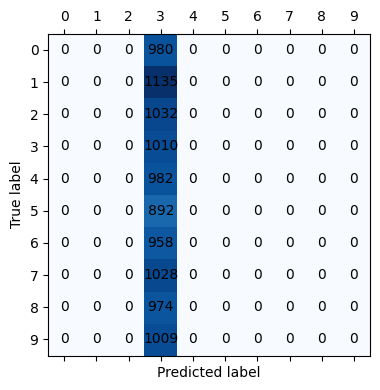

Show non-diagonal again to see errors better


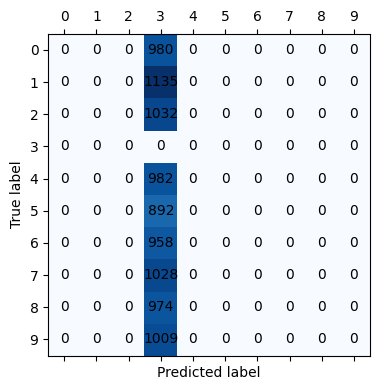

In [0]:
## Evaluate the model on the test set
test_loss, test_acc, con_mat = evaluate(model, test_dataloader)
print(f"Test loss = {test_loss:.4f}, Test accuracy = {test_acc:.4f}")
plot_confusion_matrix(con_mat)
print("Show non-diagonal again to see errors better")
plot_confusion_matrix(con_mat - torch.eye(10) * con_mat.diag())

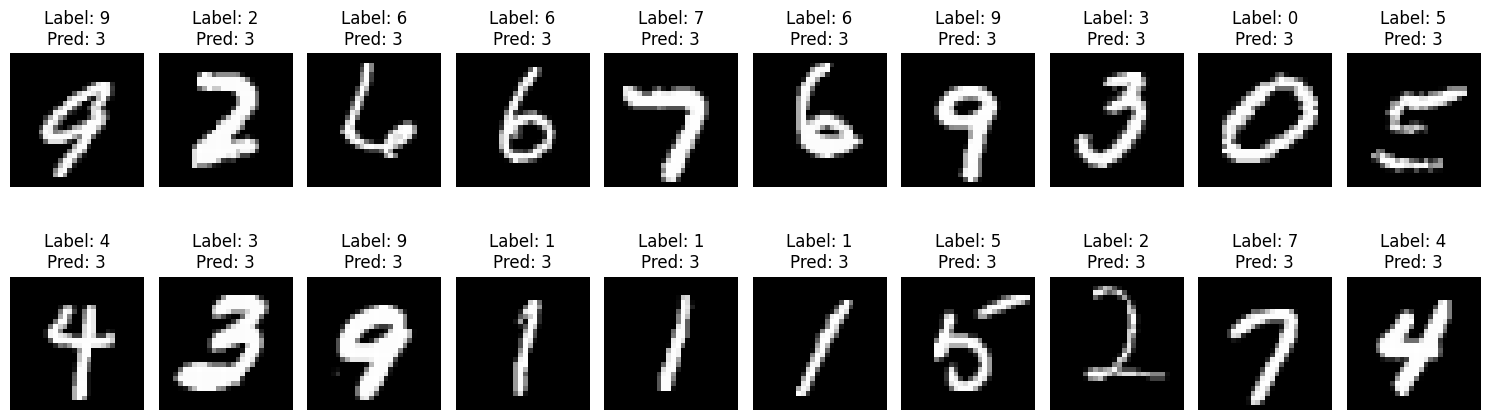

In [0]:
## Notice that we need to move the model to the cpu here since we are getting the data from the test_dataset which is on the cpu in plot_examples
plot_examples(test_dataset, model=model.to("cpu"))

Below is a bit of code to show the errors made by the model. 
Do you think the errors make sense?

What do you think this says about the trustworthiness of the model?

Number of mistakes: 8990


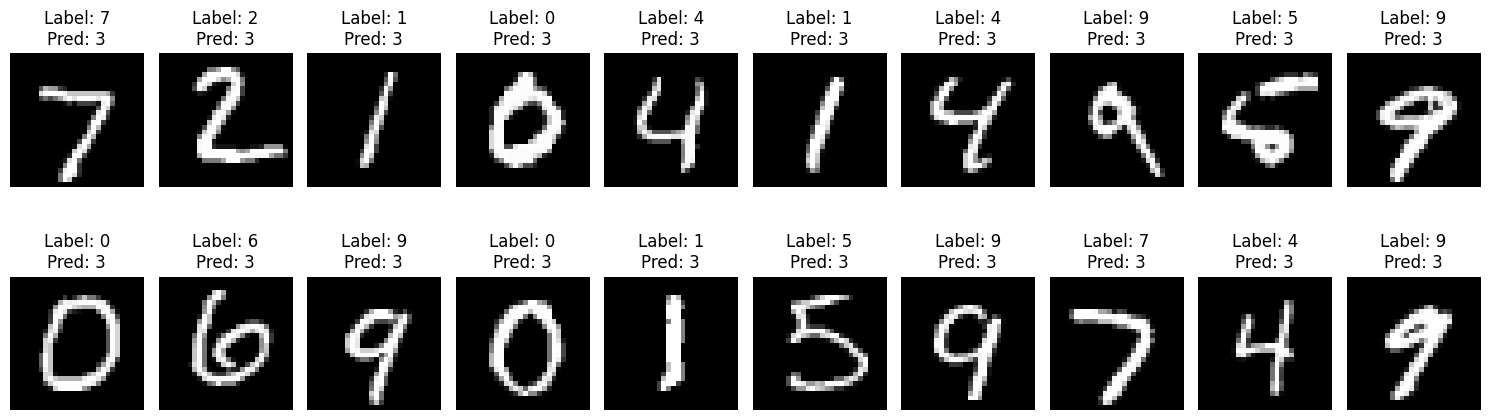

In [0]:
def find_mistakes(dataset, model):
    mistakes = []
    for img, label in dataset:
        pred = model(img.unsqueeze(0)).argmax()
        if pred != label:
            mistakes.append((img, label, pred))
    return mistakes


def show_some_mistakes(mistakes):
    fig, axes = plt.subplots(2, 10, figsize=(15, 5))
    axes = axes.ravel()
    for i, (img, label, pred) in enumerate(mistakes):
        ax = axes[i]
        ax.imshow(img[0], cmap="gray")
        ax.set_title(f"Label: {label}\nPred: {pred}")
        ax.axis("off")

        ## Show only 20 mistakes to avoid clutter and simply ignore the rest for now
        if i == 19:
            break
    plt.tight_layout()
    plt.show()


mistakes = find_mistakes(test_dataset, model)
print(f"Number of mistakes: {len(mistakes)}")
show_some_mistakes(mistakes)

### 2.9 Save and load model

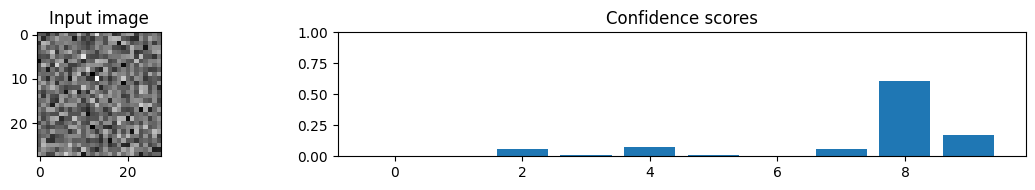

In [0]:
## save model
torch.save(model.state_dict(), "model.pth")

dummy_input = torch.randn(1, 1, 28, 28)

## load model
model = CNN(in_channels=1, num_classes=10)
model.load_state_dict(torch.load("model.pth", weights_only=True))


## Inference with PyTorch model
model.eval()
torch_outs = model(dummy_input)

## plot image with prediction confidence scores
fig, ax = plt.subplots(1, 2, figsize=(13, 2))
ax[0].imshow(dummy_input[0, 0].detach().numpy(), cmap="gray")
ax[0].set_title("Input image")
ax[1].bar(classes, torch_outs[0].softmax(0).detach().numpy())
ax[1].set_ylim([0, 1])
ax[1].set_title("Confidence scores")
plt.tight_layout()
plt.show()

**NOTICE!** how unpredictible and often confident the results are here. We are giving the model random noise and asking it to predict which digit it looks like based on its training. The most reasonable response would be as if the model had not trained, just a uniform distribution, but this is not what it gives us. We know that the model works almost perfect on the test set. However, this data looks nothing like the data it was trained on. When this happens we cannot trust the model, even though it has high confidence. 

Figuring out the limitations or bounds of understanding of a deep learning model is one of the major difficulties in deep learning in general. And thinking about how to test and validate the model is a very important part of the process. I encourage you to think hard about this when you are working on your own projects.

### 2.10 Diagnosing and Fixing Problems

During training, it's common to encounter issues that show up in your training and validation loss or accuracy curves. 
- If the **training loss decreases but validation loss increases**, you're likely **overfitting** — try fewer training epochs, reducing model capacity (size), adding **regularization** such as **weight decay (L2 regularization)** or **dropout** and maybe apply **data augmentation** or get more data if you can. 
- If **both training and validation loss stay high**, your model may be **underfitting** — try **train longer**, reduce the **learning rate**, or a **larger model**. 
- If the loss **fluctuates heavily** or fails to improve, your **learning rate may be too high** - try lowering it. 
- If training is **very slow** or the loss decreases only marginally, the **learning rate may be too low**. 
- Also consider whether your **model is too small for the task**, or your **batch size is too small**, which can make **optimization noisy**.
- **batch_size** is often a power of 2, but it is not a strict rule. It is often a good idea to try different batch sizes to see how it affects the training. In classification, where each sample does not provide that much information about the data, a batch size between `32` and `256` is common. In semantic segmentation, where each sample is a whole image, smaller batch of maybe even `2` to `16` is more common (also because of limitations of gpu memory). 

Generally, we don't want the training loss to fluctuate too much since the model might never find a good solution. However, we don't want the training to be too smooth either; since it typically leads to settling at a local minima (a suboptimal solution).

**Always monitor both loss and metrics on training and validation sets — they’re your most reliable tools for diagnosing training behavior!**


### Part 2.11: Custom Dataset

Making custom datasets is relatively easy in PyTorch. You need to subclass `torch.utils.data.Dataset` and implement `__len__` and `__getitem__`.

- `__len__` returns the size of the dataset and is the method that is called when running `len(dataset)`.
- `__getitem__` is used to retrieve a sample from the dataset at a given index such as `dataset[0]`.

See the example below:

In [0]:
## Example
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, data_arg=None):
        super().__init__()
        self.n_data_points = 100
        self.data_arg = data_arg

    def __len__(self):
        return self.n_data_points

    def __getitem__(self, idx):
        dummy_input_data = torch.randn(1, 28, 28)
        dummy_label = torch.randint(0, 10, (1,))
        return dummy_input_data, dummy_label


dataset = CustomDataset()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)

for inputs, labels in dataloader:
    print(inputs.shape, labels.shape)
    break

torch.Size([2, 1, 28, 28]) torch.Size([2, 1])


## Part 3: Modify and Experiment with the Pipeline

Now we have some tasks for you to use what we have covered. In the lab session, you will be given the same code illustrated above (for data loading, model definition, and training loop). Your tasks is to make modifications and observing the effects. Here are the specific exercises: 

1. **Swap the Dataset:** Modify the code to train the CNN on a different image dataset. You can use a built-in dataset like CIFAR-10 (comment out above), FashionMNIST or others. This exercise will help you understand how to swap datasets in PyTorch and observe how the model performs on different data distributions. Also, you will probably have to make some adaptations to the model itself to accept the size of the data you are using.

2. **Modify the Model Architecture:** Increase or decrease the complexity of the model and observe the impact. For instance, add an additional convolutional layer (making it three conv layers in total), or increase the number of neurons in the fully connected layers, or insert a `nn.Dropout` layer after `conv2` or between the FC layers. Train the modified model for a few epochs. Does it achieve lower training loss or higher accuracy? Also watch if it overfits more quickly due to increased capacity. 

3. **Tweak Training Hyperparameters:** Experiment with the training loop settings. Try a higher learning rate (e.g. 0.1) and see if the model converges faster or if it becomes unstable. Alternatively, change the batch size (e.g. 512 or 2 instead of 64) – note how that affects the training speed per epoch and the stability of updates. You can also enable weight decay in the optimizer (e.g. `optim.SGD(..., weight_decay=1e-4)`) which adds restrictions on the absolute size the weights. This limits the model and combats overfitting. The purpose here is to develop intuition on how hyperparameters like learning rate and batch size influence the training. 

4. **Convert to an Autoencoder:** An autoencoder is a network trained to reconstruct its input as we have seen in the lectures. Try modifying the CNN architecture into an autoencoder. For example, use the current CNN as an **encoder** (downsampling image to a feature vector), then add a **decoder** that mirrors it (up-sampling back to the original image size using transpose convolutions or interpolation). Train the autoencoder on a dataset of images where the “labels” are the inputs themselves. Note that this would be regression instead of classification so you will need to change not only the data and the model, but also the loss function.


## Summary
In this tutorial, we have discussed the basics of working with PyTorch tensors, including moving computations to the GPU, getting gradients with `autograd`, and converting between NumPy arrays and PyTorch tensors. 

We then built and trained a simple CNN from scratch, covering the key components of a deep learning pipeline: 
- datasets
- model architecture
- loss functions
- optimizers
- evaluation metrics
- training and evaluation loops
- saving and loading models
- diagnosing and fixing training issues

Finally, we provided a few exercises to help you experiment with the pipeline.